In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

# 加载数据

In [2]:
data = pd.read_csv('../../data/criteo_sampled_data.csv')
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [3]:
cols = data.columns.values

# 数据预处理

## 定义特征组

In [4]:
dense_feats = [f for f in cols if f[0] == "I"]
sparse_feats = [f for f in cols if f[0] == "C"]

## 处理dense特征

In [5]:
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    return d

In [6]:
data_dense = process_dense_feats(data, dense_feats)

## 处理sparse特征

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
        
    return d

In [9]:
data_sparse = process_sparse_feats(data, sparse_feats)

In [10]:
total_data = pd.concat([data_dense, data_sparse], axis=1)

In [11]:
total_data['label'] = data['label']

# 模型构建与训练

## 输入层

### dense特征

In [12]:
import tensorflow as tf

In [13]:
dense_inputs = []
for f in dense_feats:
    _input = Input([1], name=f)
    dense_inputs.append(_input)

In [14]:
dense_inputs

[<tf.Tensor 'I1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I3:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I4:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I5:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I6:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I7:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I8:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I9:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I10:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I11:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I12:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'I13:0' shape=(None, 1) dtype=float32>]

In [15]:
concat_dense_inputs = Concatenate(axis=1)(dense_inputs)

In [16]:
concat_dense_inputs

<tf.Tensor 'concatenate/concat:0' shape=(None, 13) dtype=float32>

### sparse特征

In [17]:
sparse_inputs = []
for f in sparse_feats:
    _input = Input([1], name=f)
    sparse_inputs.append(_input)

In [18]:
k = 8

In [19]:
sparse_kd_embed = []
for _input in sparse_inputs:
    f = _input.name.split(':')[0]
    voc_size = data[f].nunique()
    _embed = Flatten()(Embedding(voc_size+1, k, embeddings_regularizer=tf.keras.regularizers.l2(0.7))(_input))
    sparse_kd_embed.append(_embed)

In [20]:
sparse_kd_embed

[<tf.Tensor 'flatten/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_1/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_2/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_3/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_4/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_5/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_6/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_7/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_8/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_9/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_10/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_11/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_12/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_13/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Tensor 'flatten_14/Reshape:0' shape=(None, 8) dtype=float32>,
 <tf.Te

In [21]:
concat_sparse_inputs = Concatenate(axis=1)(sparse_kd_embed)

In [22]:
concat_sparse_inputs

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 208) dtype=float32>

### 所有输入embedding

In [23]:
embed_inputs = Concatenate(axis=1)([concat_sparse_inputs, concat_dense_inputs])

In [24]:
embed_inputs

<tf.Tensor 'concatenate_2/concat:0' shape=(None, 221) dtype=float32>

## Cross Network

In [25]:
def cross_layer(x0, xl):
    """
    实现一层cross layer
    @param x0: 特征embeddings
    @param xl: 第l层的输出结果
    """
    # 1.获取xl层的embedding size
    embed_dim = xl.shape[-1]
    # 2.初始化当前层的W和b
    w = tf.Variable(tf.random.truncated_normal(shape=(embed_dim,), stddev=0.01))
    b = tf.Variable(tf.zeros(shape=(embed_dim,)))
    # 3.计算feature crossing
    x_lw = tf.tensordot(tf.reshape(xl, [-1, 1, embed_dim]), w, axes=1)
    cross = x0 * x_lw 
    return cross + b + xl

In [26]:
def build_cross_layer(x0, num_layer=3):
    """
    构建多层cross layer
    @param x0: 所有特征的embeddings
    @param num_layers: cross net的层数
    """
    # 初始化xl为x0
    xl = x0
    # 构建多层cross net
    for i in range(num_layer):
        xl = cross_layer(x0, xl)
    
    return xl

In [27]:
# cross net
cross_layer_output = build_cross_layer(embed_inputs, 3)

In [28]:
cross_layer_output

<tf.Tensor 'AddV2_5:0' shape=(None, 221) dtype=float32>

## DNN部分

In [29]:
fc_layer = Dropout(0.5)(Dense(128, activation='relu')(embed_inputs))
fc_layer = Dropout(0.3)(Dense(128, activation='relu')(fc_layer))
fc_layer_output = Dropout(0.1)(Dense(128, activation='relu')(fc_layer))

In [30]:
fc_layer_output

<tf.Tensor 'dropout_2/cond/Identity:0' shape=(None, 128) dtype=float32>

## 输出结果

In [31]:
cross_layer_output

<tf.Tensor 'AddV2_5:0' shape=(None, 221) dtype=float32>

In [32]:
fc_layer_output

<tf.Tensor 'dropout_2/cond/Identity:0' shape=(None, 128) dtype=float32>

In [33]:
stack_layer = Concatenate()([cross_layer_output, fc_layer_output])

In [34]:
output_layer = Dense(1, activation='sigmoid', use_bias=True)(stack_layer)

## 编译模型

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [36]:
model = Model(dense_inputs+sparse_inputs, output_layer)

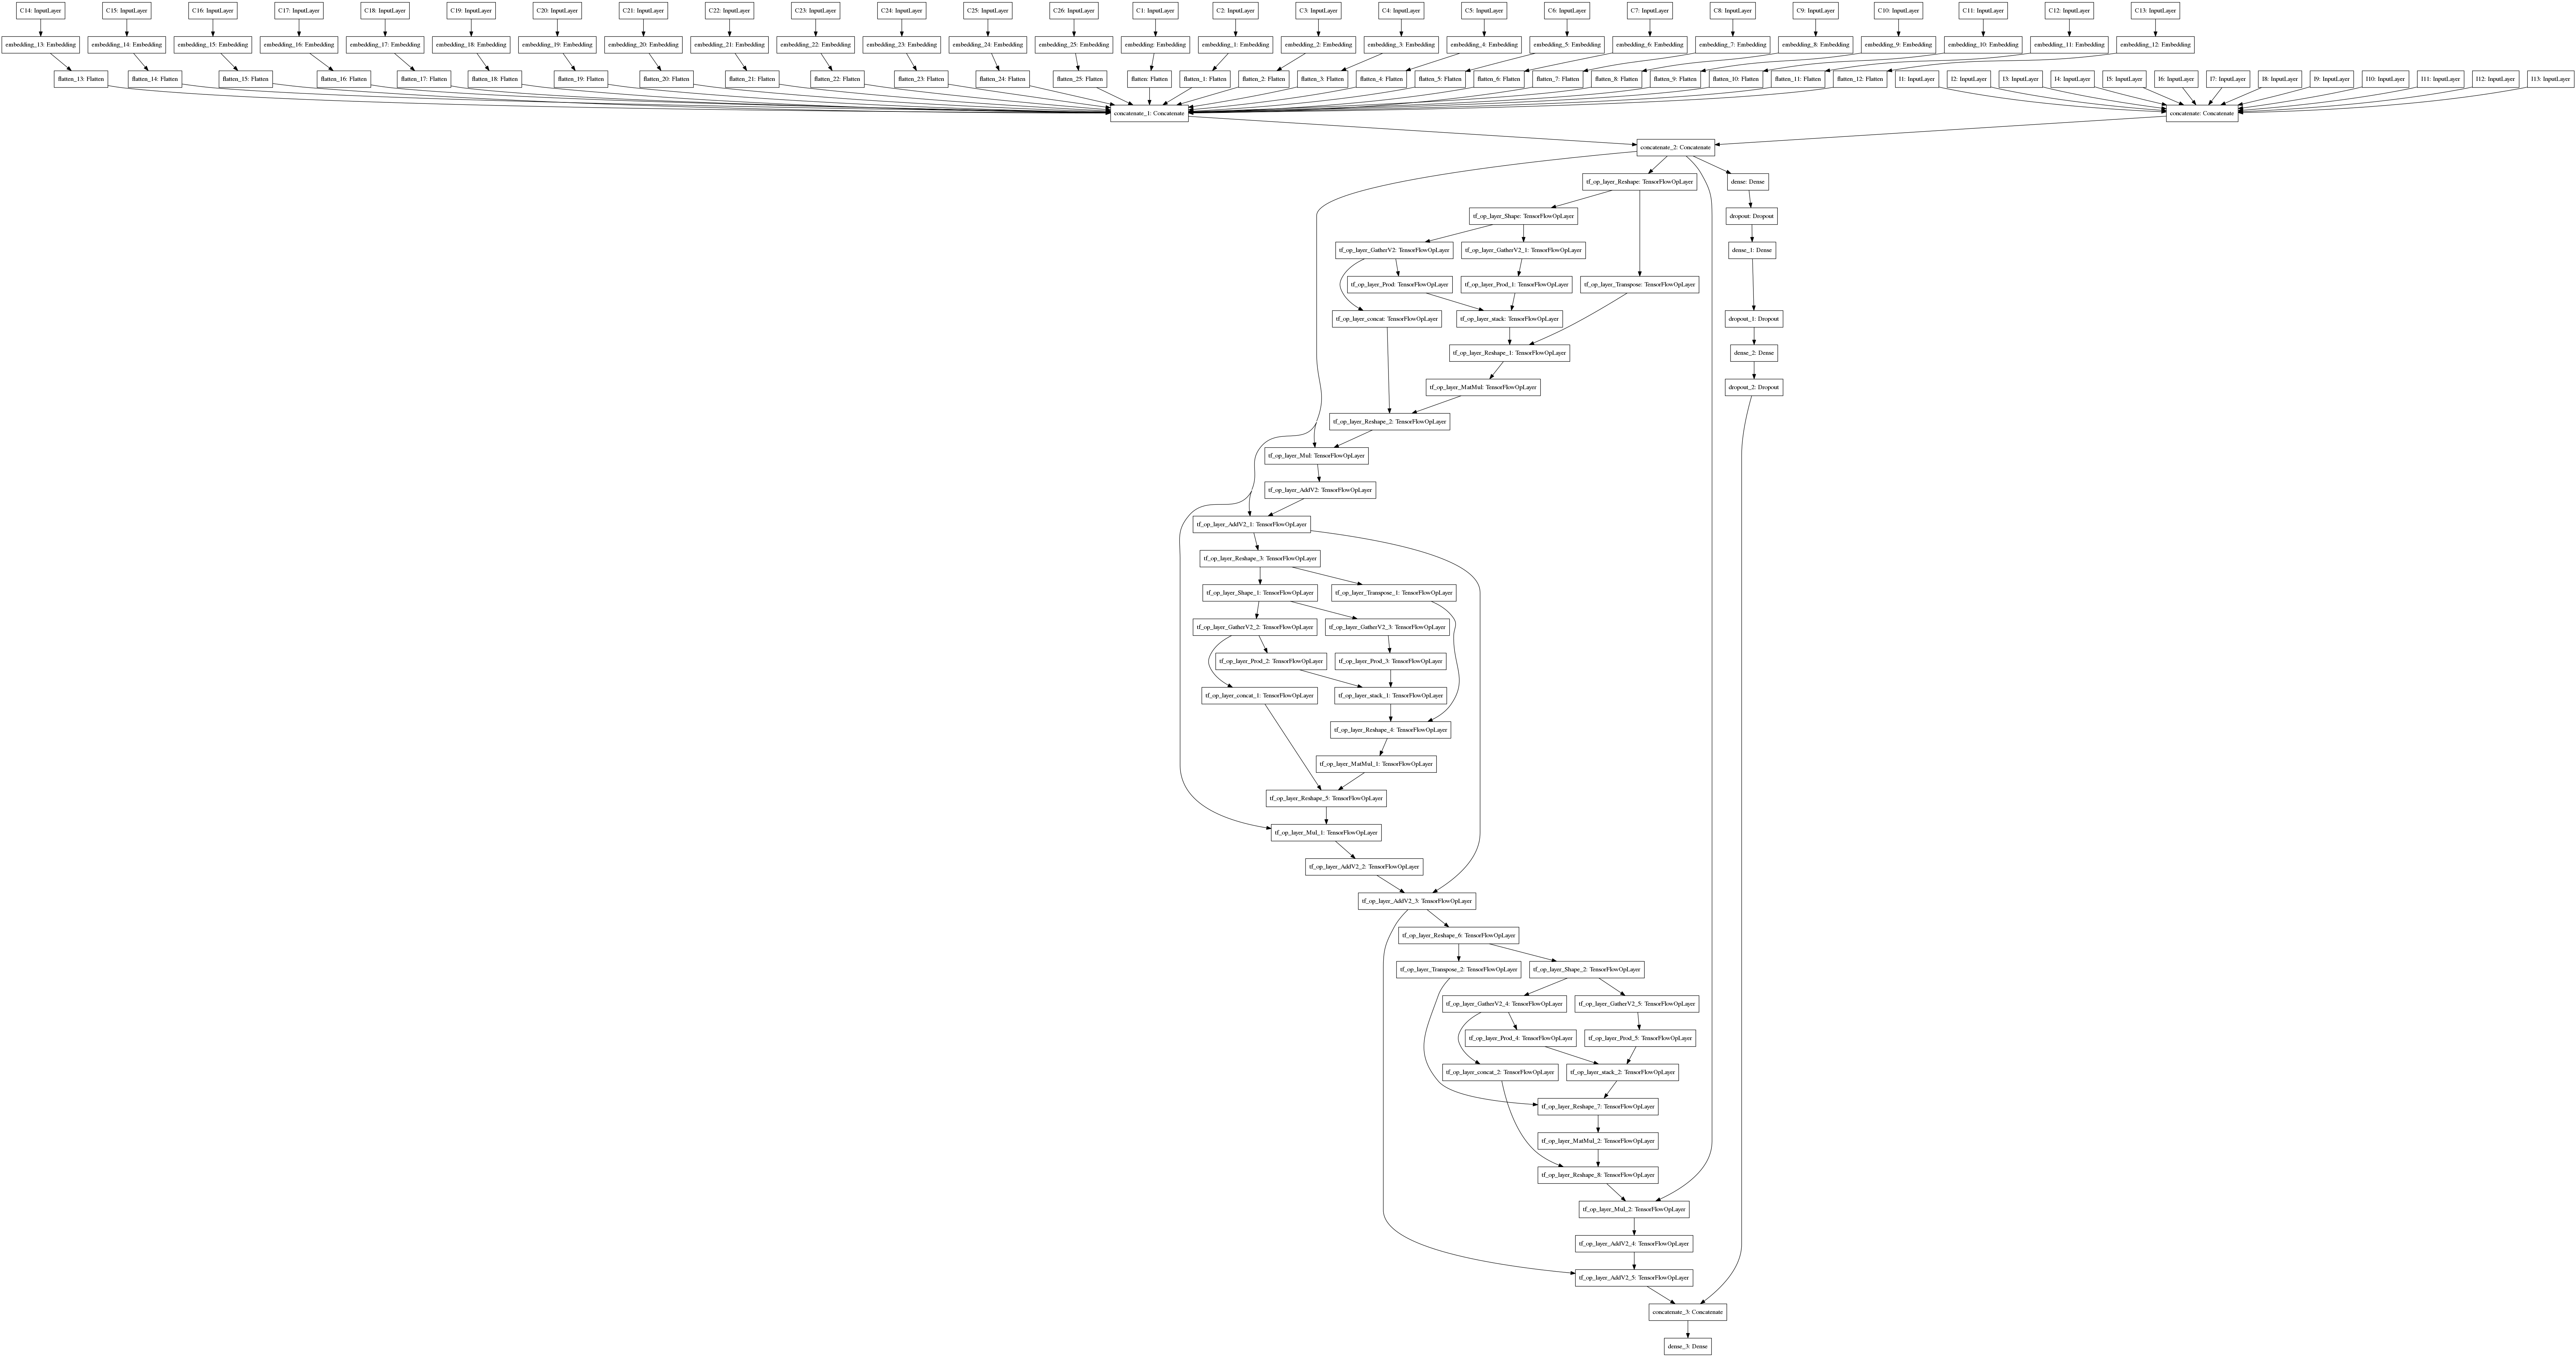

In [37]:
plot_model(model, "dcn.png")

In [38]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 [(None, 1)]          0                                            
_______________________________________________________________________________________

In [39]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

## 训练

In [40]:
from tensorflow.keras.callbacks import TensorBoard

In [41]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  
                 write_graph=True,  
                 write_grads=True, 
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [42]:
train_data = total_data.loc[:500000-1]
valid_data = total_data.loc[500000:]

In [43]:
train_dense_x = [train_data[f].values for f in dense_feats]
train_sparse_x = [train_data[f].values for f in sparse_feats]

In [44]:
train_label = [train_data['label'].values]

In [45]:
val_dense_x = [valid_data[f].values for f in dense_feats]
val_sparse_x = [valid_data[f].values for f in sparse_feats]

In [46]:
val_label = [valid_data['label'].values]

In [48]:
history = model.fit(train_dense_x+train_sparse_x, 
          train_label, epochs=5, batch_size=128,
          validation_data=(val_dense_x+val_sparse_x, val_label),
          callbacks=[tbCallBack]
         )

Epoch 1/5
3907/3907 [==============================] - 54s 14ms/step - loss: 0.5994 - binary_crossentropy: 0.4984 - auc: 0.7360 - val_loss: 0.6124 - val_binary_crossentropy: 0.5037 - val_auc: 0.7337
Epoch 2/5
3907/3907 [==============================] - 54s 14ms/step - loss: 0.6028 - binary_crossentropy: 0.4981 - auc: 0.7367 - val_loss: 0.6160 - val_binary_crossentropy: 0.5031 - val_auc: 0.7337
Epoch 3/5
3907/3907 [==============================] - 54s 14ms/step - loss: 0.6020 - binary_crossentropy: 0.4975 - auc: 0.7375 - val_loss: 0.6229 - val_binary_crossentropy: 0.5030 - val_auc: 0.7336
Epoch 4/5
3907/3907 [==============================] - 53s 14ms/step - loss: 0.6032 - binary_crossentropy: 0.4969 - auc: 0.7383 - val_loss: 0.6145 - val_binary_crossentropy: 0.5030 - val_auc: 0.7331
Epoch 5/5
3907/3907 [==============================] - 53s 14ms/step - loss: 0.6035 - binary_crossentropy: 0.4965 - auc: 0.7389 - val_loss: 0.6111 - val_binary_crossentropy: 0.5031 - val_auc: 0.7341


In [50]:
history.history

{'loss': [0.5993915796279907,
  0.6027824878692627,
  0.6020224094390869,
  0.6032356023788452,
  0.6035240888595581],
 'binary_crossentropy': [0.4984417259693146,
  0.4980884790420532,
  0.4974620044231415,
  0.49692806601524353,
  0.49650540947914124],
 'auc': [0.7360180616378784,
  0.7366654872894287,
  0.737479031085968,
  0.7382845878601074,
  0.7388569116592407],
 'val_loss': [0.6124424338340759,
  0.6159824132919312,
  0.622946560382843,
  0.6145056486129761,
  0.6110712289810181],
 'val_binary_crossentropy': [0.5036731958389282,
  0.5030748248100281,
  0.5030178427696228,
  0.5029816627502441,
  0.5031424760818481],
 'val_auc': [0.7336623072624207,
  0.7337033748626709,
  0.733597993850708,
  0.7330537438392639,
  0.734123945236206]}